In [1]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as nd_sum
from scipy.ndimage import zoom
import tifffile
import openslide
from PIL import Image

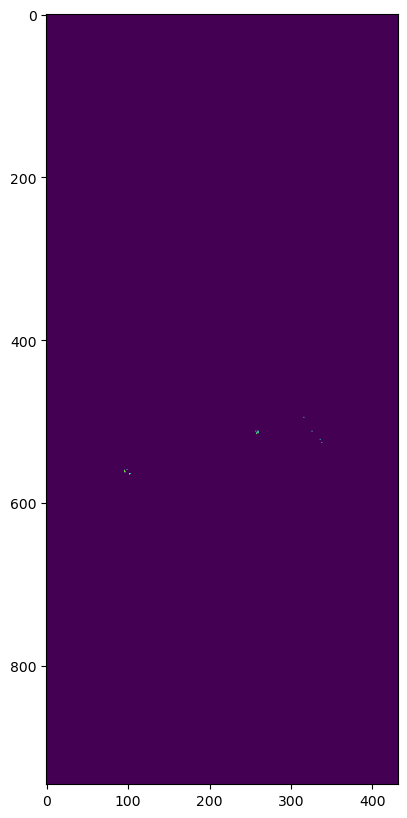

In [2]:
# pick the slide
slide_name = 'test_051'
mask_file = 'C10_P11_0.3.npy'

# corresponding mask in './experimentData/trainSlidesCorrectDaignosis.csv'
# GAZE_MASK_PATH = '/fs/ess/PAS1575/Dataset/new_data/fixation_masks/fixation_reduction/'
GAZE_MASK_PATH = "/fs/ess/PAS1575/Dataset/merged_masks/Heatmaps/no_initial/20macro/fixation_reduction/"
mask_name = GAZE_MASK_PATH + mask_file

mask_gaze = np.load(mask_name)
new_h, new_w = mask_gaze.shape[0]/(224/32), mask_gaze.shape[1]/(224/32)

# convert to Image image and resize
mask_img = Image.fromarray(mask_gaze)
mask_pfmap = mask_img.resize((int(new_w), int(new_h)))
mask_pfmap = np.array(mask_pfmap)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mask_pfmap)

In [3]:
slide = openslide.OpenSlide(f'/fs/ess/PAS1575/Dataset/CAMELYON16/testing/images/{slide_name}.tif')
width, height = slide.dimensions

# Calculate the size of the thumbnail
thumbnail_size = (width // 224, height // 224)

# Get the thumbnail
thumbnail = slide.get_thumbnail(thumbnail_size)

Original mask shape: (211968, 96768)
432 946
sum of tumor pixels 0


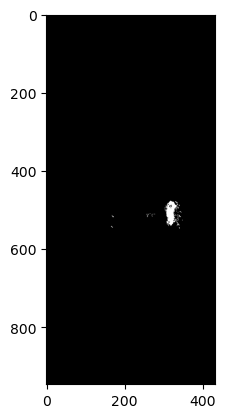

In [4]:
# display ground truth mask
gt_path = f'/fs/ess/PAS1575/Dataset/CAMELYON16/testing_masks/{slide_name}_mask.tif'
# Read the ground truth mask
gt_mask = tifffile.imread(gt_path)

# Display the original mask shape
print(f"Original mask shape: {gt_mask.shape}")

# Shrink the mask by a factor of 224 (downsize)
# Since we are shrinking, we use a zoom factor of 1/224 for both dimensions
shrink_factor = 1 / 224
shrunk_mask = zoom(gt_mask, zoom=shrink_factor, order=0)  # Nearest-neighbor interpolation (order=0)

slide_width = shrunk_mask.shape[1]
slide_height = shrunk_mask.shape[0]
print(slide_width, slide_height)
print('sum of tumor pixels', np.sum(shrunk_mask>1))

# Display the shrunk mask
plt.imshow(shrunk_mask>0, cmap='gray')

40 to 351, 472 to 731


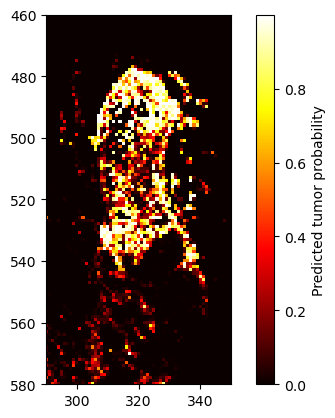

In [11]:
# draw prediction probability
df = pd.read_csv(f'whole_slide_prediction/{slide_name}.csv')

# Get the smallest and largest x and y coordinates from the DataFrame
min_x = df['x'].min()
min_y = df['y'].min()
max_x = df['x'].max()
max_y = df['y'].max()
print(f'{min_x} to {max_x}, {min_y} to {max_y}')

# # Initialize an empty mask with the size based on the full range of x and y coordinates
# mask_width = max_x + 1  # Add 1 because coordinates are zero-indexed
# mask_height = max_y + 1
# mask = np.zeros((mask_height, mask_width), dtype=np.float32)

mask = np.zeros((slide_height, slide_width), dtype=np.float32)

# Fill the mask with the probability values from yhat at the given x and y coordinates
for _, row in df.iterrows():
    x, y, yhat = int(row['x']), int(row['y']), row['yhat']
    mask[y, x] = yhat  # y is row index, x is column index

# Display the mask using matplotlib
plt.imshow(mask, cmap='hot', interpolation='nearest')
plt.xlim(290, 350)
plt.ylim(580, 460)
plt.colorbar(label='Predicted tumor probability')
# plt.title('Tumor Probability Mask')

orignal mask top-left (40, 472), bottom-right (351, 731)
cleaned mask top-left (115, 477), bottom-right (339, 619)


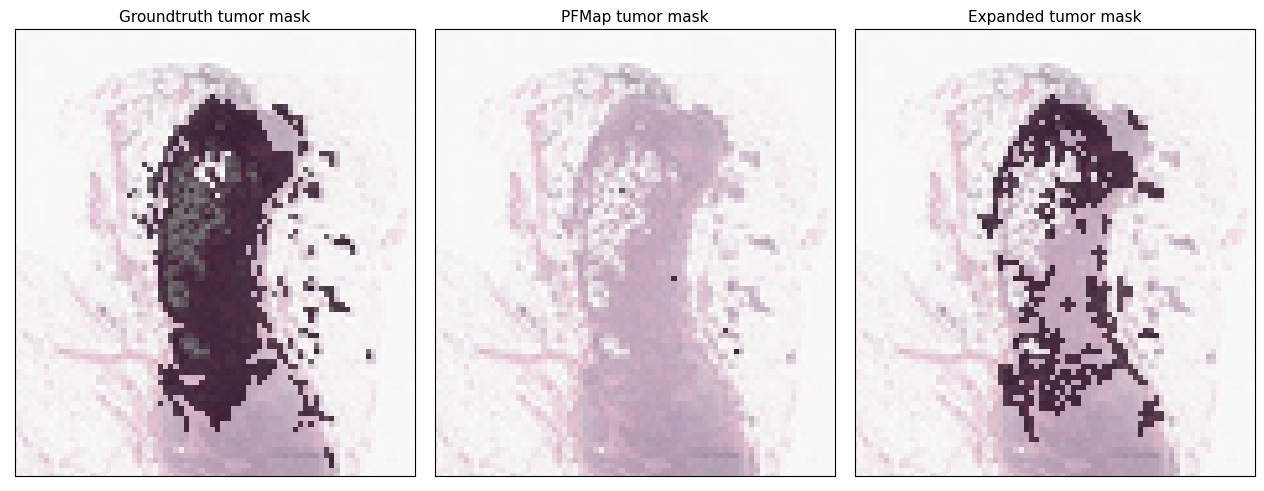

In [ ]:
# Threshold the mask to create a binary mask (1 for tumor areas, 0 for others)
binary_mask = (mask > 0.5).astype(int)

# Label connected components in the binary mask
labeled_mask, num_features = label(binary_mask)

# Calculate the size of each component
component_sizes = nd_sum(binary_mask, labeled_mask, index=np.arange(1, num_features + 1))

# Filter out small components
cleaned_binary_mask = binary_mask.copy()

size_threshold = 3  # Minimum size of regions to keep (in pixels)

for i, size in enumerate(component_sizes):
    if size < size_threshold:
        # Set small components to 0 in the labeled mask
        cleaned_binary_mask[labeled_mask == (i + 1)] = 0      

# Find the new bounding box of the filtered mask (non-zero regions)
non_zero_coords = np.argwhere(cleaned_binary_mask > 0)
top_left = non_zero_coords.min(axis=0)  # Get the top-left (min y, min x)
bottom_right = non_zero_coords.max(axis=0)  # Get the bottom-right (max y, max x)

print(f'orignal mask top-left ({min_x}, {min_y}), bottom-right ({max_x}, {max_y})')
new_min_x, new_min_y = top_left[1], top_left[0]
print(f'cleaned mask top-left ({new_min_x}, {new_min_y}), bottom-right ({bottom_right[1]}, {bottom_right[0]})')

# Extract the bounding box of the filtered mask
cleaned_binary_mask_cropped = cleaned_binary_mask[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]

# # Save the mask as a .npy file
# output_filename = f'path_to_save/{slide_name}_{new_min_x}_{new_min_y}.npy'
# np.save(output_filename, cleaned_binary_mask_cropped)

# Display the original and filtered masks side by side
fig, axs = plt.subplots(1, 3, figsize=(16, 9))  # 

alpha = 0.5
cmap = 'gray_r'

xmin, xmax = 280, 357  # tumor_016
ymin, ymax = 464, 550

axs[0].imshow(thumbnail)
axs[0].imshow(shrunk_mask>0, cmap=cmap, alpha=alpha)
axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].set_title('Groundtruth tumor mask', fontsize=11)
axs[0].set_ylim(ymax, ymin)  
axs[0].set_xlim(xmin, xmax)

axs[1].imshow(thumbnail)
axs[1].imshow(mask_pfmap, cmap=cmap, alpha=alpha)
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].set_title('PFMap tumor mask', fontsize=11)
axs[1].set_ylim(ymax, ymin)
axs[1].set_xlim(xmin, xmax)

axs[2].imshow(thumbnail)
axs[2].imshow(cleaned_binary_mask, cmap=cmap, alpha=alpha)
axs[2].set_yticks([])
axs[2].set_xticks([])
axs[2].set_title('Expanded tumor mask', fontsize=11)
axs[2].set_ylim(ymax, ymin)
axs[2].set_xlim(xmin, xmax)

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'./masks_plots/{slide_name}.png', dpi=300, bbox_inches='tight')

## Calculate stats between the masks

In [15]:
def calculate_precision_recall(gt_mask, pred_mask):
    """
    Calculate precision and recall for the predicted mask against the ground truth mask.

    Parameters:
    gt_mask (np.array): Ground truth mask (2D array with 0 for normal and 1 for tumor)
    pred_mask (np.array): Predicted mask (2D array with 0 for normal and 1 for tumor)

    Returns:
    precision (float): Precision of the predicted mask
    recall (float): Recall of the predicted mask
    """
    # Determine the smaller dimensions
    min_height = min(gt_mask.shape[0], pred_mask.shape[0])
    min_width = min(gt_mask.shape[1], pred_mask.shape[1])
    
    # Crop both masks to the smaller dimensions
    gt_mask_cropped = gt_mask[:min_height, :min_width]
    pred_mask_cropped = pred_mask[:min_height, :min_width]
    
    # True positives (TP): Tumor in both gt_mask and pred_mask
    TP = np.sum((gt_mask_cropped == 1) & (pred_mask_cropped == 1))
    
    # False positives (FP): Tumor in pred_mask but not in gt_mask
    FP = np.sum((gt_mask_cropped == 0) & (pred_mask_cropped == 1))
    
    # False negatives (FN): Tumor in gt_mask but not in pred_mask
    FN = np.sum((gt_mask_cropped == 1) & (pred_mask_cropped == 0))

    print(TP, FP, FN)
    
    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

In [18]:
gt_mask = shrunk_mask>0
pred_mask = mask_pfmap

precision, recall = calculate_precision_recall(gt_mask, pred_mask)
print(f'Precision: {precision}, Recall: {recall}')

212 11 2972
Precision: 0.9506726457399103, Recall: 0.06658291457286432
